In [25]:
import pandas as pd
import numpy as np

df = pd.read_csv('all_data.csv')
df = df.dropna(subset=['pm25'])
df

,Unnamed: 0.1,Unnamed: 0,date,stacja,pm25,temperature_2m_min,wind_speed_10m_max,wind_direction_10m_dominant,cloud_cover_mean,surface_pressure_mean,...,boundary_layer_height,lat,lon,nearest_road_dist_m,total_road_length_km,building_count,elevation,population,built_up_surface,built_up_volume
0,0,0,2016-01-01 00:00:00+00:00,DsLegAlRzecz,59.30,-1.932500,11.753877,289.29013,100.000000,1010.14970,...,191.66667,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
1,1,1,2016-01-02 00:00:00+00:00,DsLegAlRzecz,54.70,-9.532500,22.896110,102.65439,59.958332,1009.82965,...,433.12500,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
2,2,2,2016-01-03 00:00:00+00:00,DsLegAlRzecz,69.00,-12.282500,18.709612,107.50388,49.416668,1003.64520,...,398.33334,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
3,3,3,2016-01-04 00:00:00+00:00,DsLegAlRzecz,80.10,-10.632501,20.696087,118.76107,92.458336,985.55080,...,477.91666,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
4,4,4,2016-01-05 00:00:00+00:00,DsLegAlRzecz,100.50,-7.082500,13.324863,86.64323,95.750000,985.00410,...,268.75000,51.204503,16.180513,98.613062,942.949585,15745.0,124.0,101762.211892,6385774.0,45643207.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66912,66912,66912,2018-12-28 00:00:00+00:00,ZpSzczec1Maj,4.90,4.139000,24.535526,298.53427,100.000000,1003.10750,...,728.54170,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66913,66913,66913,2018-12-29 00:00:00+00:00,ZpSzczec1Maj,8.16,3.889000,17.555307,256.10280,99.958336,1004.09380,...,552.08330,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66914,66914,66914,2018-12-30 00:00:00+00:00,ZpSzczec1Maj,4.35,1.689000,27.002400,298.98737,95.958336,1000.37670,...,665.83330,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0
66915,66915,66915,2018-12-31 00:00:00+00:00,ZpSzczec1Maj,7.44,1.839000,20.883102,271.19727,98.791664,1009.56620,...,395.62500,53.712114,16.692517,23.818303,544.823893,8120.0,138.0,43274.445438,2695519.0,19724737.0


In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Przetwórz datę
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday



# Lista zmiennych pogodowych, dla których zrobimy lag
weather_features = ['temperature_2m_min', 'wind_speed_10m_max', 'cloud_cover_mean', 'wind_direction_10m_dominant',
            'surface_pressure_mean', 'dew_point_2m_mean',
            'boundary_layer_height',]

# Tworzenie lag features (lag 1 i lag 2 dni) dla każdej stacji
df = df.sort_values(['stacja', 'date'])
for feature in weather_features:
    df[f'{feature}_lag1'] = df.groupby('stacja')[feature].shift(1)
    df[f'{feature}_lag2'] = df.groupby('stacja')[feature].shift(2)

# Po utworzeniu lagów mogą pojawić się NaNy na początkowych wierszach każdej stacji - usuwamy je
df = df.dropna(subset=[f'{f}_lag1' for f in weather_features] + [f'{f}_lag2' for f in weather_features])

# Definicja cech i targetu
features = ['temperature_2m_min', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
            'cloud_cover_mean', 'surface_pressure_mean', 'dew_point_2m_mean',
            'boundary_layer_height',
            'nearest_road_dist_m', 'total_road_length_km', 'building_count',
            'elevation', 'population', 'built_up_surface', 'built_up_volume',
            'year', 'month', 'day', 'weekday']

# Dodajemy lagi do listy cech
for feature in weather_features:
    features.append(f'{feature}_lag1')
    features.append(f'{feature}_lag2')

target = 'pm25'

# Inicjalizacja list na dane treningowe i testowe
train_list = []
test_list = []

# Podział danych dla każdej stacji osobno
for stacja, group in df.groupby('stacja'):
    # Sortuj po dacie, by mieć porządek czasowy
    group = group.sort_values('date')
    
    # Przykład: użyj 80% pierwszych dat jako trening, pozostałe jako test
    split_index = int(len(group) * 0.8)
    
    train_list.append(group.iloc[:split_index])
    test_list.append(group.iloc[split_index:])

# Scal ponownie zbiory treningowy i testowy
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Przygotuj X i y
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


In [27]:
# Trenuj model
rf = RandomForestRegressor(n_estimators=100, verbose=2, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Predykcje i ocena
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Train R2 score:", r2_score(y_train, y_pred_train))
print("Test R2 score:", r2_score(y_test, y_pred_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.5s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


Train R2 score: 0.9682302981306855
Test R2 score: 0.6169782870311029


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


RMSE: 8.94
R² score: 0.62
Bias: 0.81


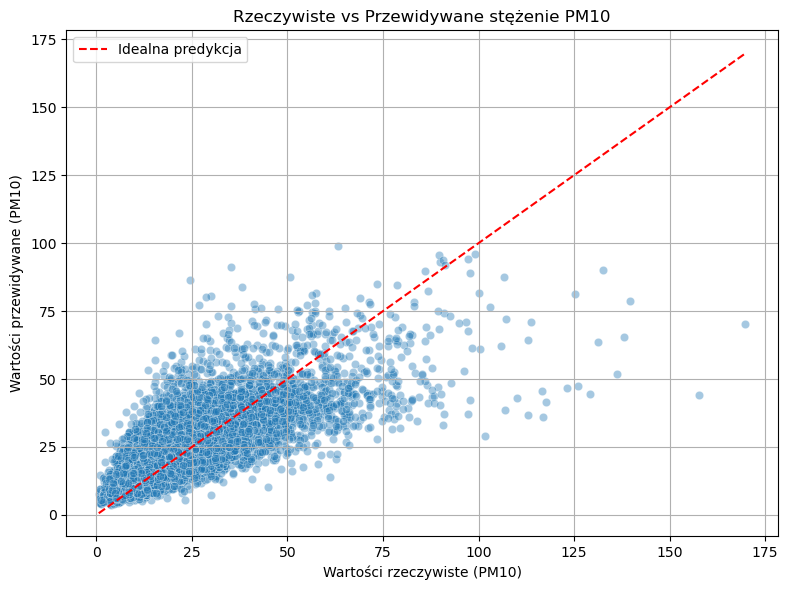

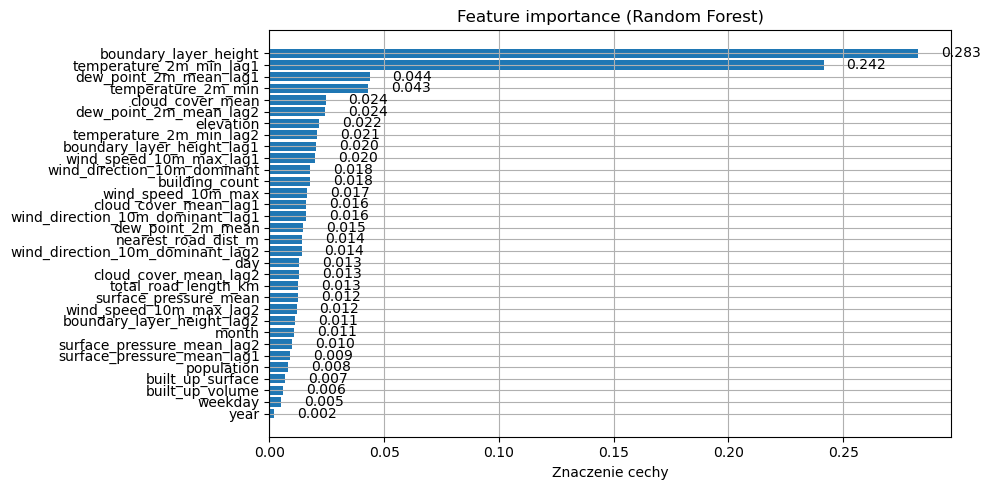

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rf.predict(X_test)
# Metryki
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

bias = y_pred - y_test

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.2f}")
print(f"Bias: {bias.mean():.2f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Tworzymy wykres scatter z linią idealnej predykcji
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)

# Linia idealna: predykcja == rzeczywistość
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Idealna predykcja')

plt.xlabel("Wartości rzeczywiste (PM10)")
plt.ylabel("Wartości przewidywane (PM10)")
plt.title("Rzeczywiste vs Przewidywane stężenie PM10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


importances = rf.feature_importances_
feature_names = X.columns

# Posortuj cechy według znaczenia (opcjonalnie)
indices = np.argsort(importances)
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

plt.figure(figsize=(10, 5))
bars = plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Znaczenie cechy')
plt.title('Feature importance (Random Forest)')
plt.grid(True)

# Dodaj wartości liczbowe do końca słupków
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Przetwórz datę
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday


# Lista zmiennych pogodowych, dla których zrobimy lag
weather_features = ['temperature_2m_min', 'wind_speed_10m_max', 'cloud_cover_mean', 'wind_direction_10m_dominant',
            'surface_pressure_mean', 'dew_point_2m_mean',
            'boundary_layer_height',]

# Tworzenie lag features (lag 1 i lag 2 dni) dla każdej stacji
df = df.sort_values(['stacja', 'date'])
for feature in weather_features:
    df[f'{feature}_lag1'] = df.groupby('stacja')[feature].shift(1)
    df[f'{feature}_lag2'] = df.groupby('stacja')[feature].shift(2)

# Po utworzeniu lagów mogą pojawić się NaNy na początkowych wierszach każdej stacji - usuwamy je
df = df.dropna(subset=[f'{f}_lag1' for f in weather_features] + [f'{f}_lag2' for f in weather_features])

# Definicja cech i targetu
features = ['temperature_2m_min', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
            'cloud_cover_mean', 'surface_pressure_mean', 'dew_point_2m_mean',
            'boundary_layer_height',
            'nearest_road_dist_m', 'total_road_length_km', 'building_count',
            'elevation', 'population', 'built_up_surface', 'built_up_volume',
            'year', 'month', 'day', 'weekday']

# Dodajemy lagi do listy cech
for feature in weather_features:
    features.append(f'{feature}_lag1')
    features.append(f'{feature}_lag2')

X = df[features]
y = df['pm25']

# Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf = RandomForestRegressor(n_estimators=100, verbose=2, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Ocena
print("Train score:", rf.score(X_train, y_train))
print("Test score:", rf.score(X_test, y_test))


Train score: 0.9669144067075266
Test score: 0.7525081452075733


RMSE: 9.85
R² score: 0.75


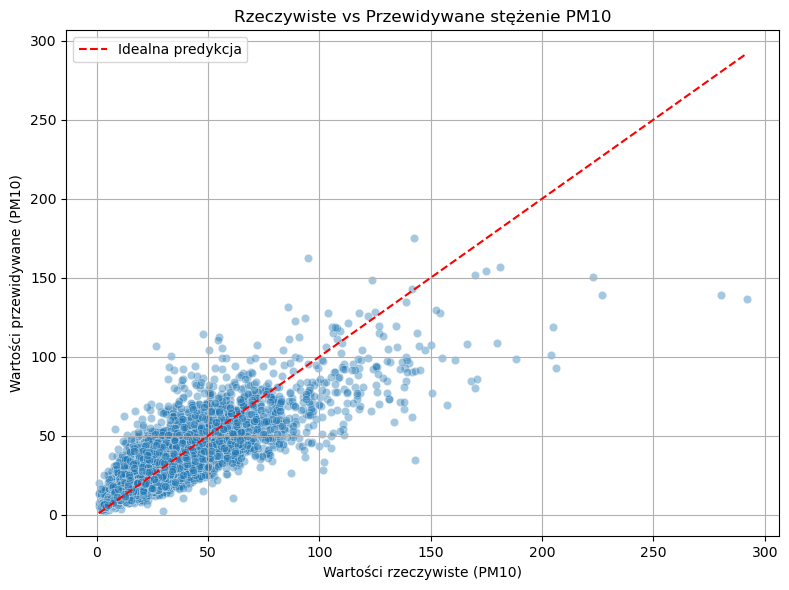

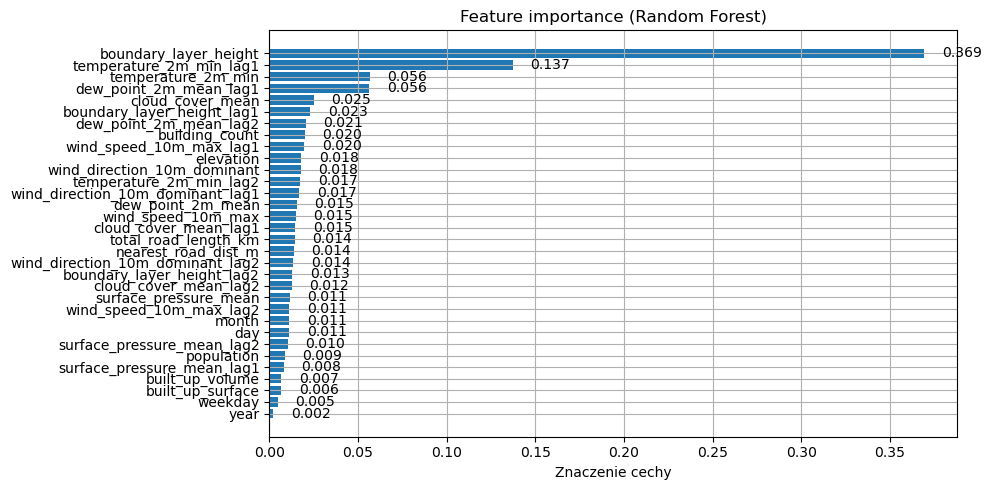

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rf.predict(X_test)
# Metryki
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Tworzymy wykres scatter z linią idealnej predykcji
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)

# Linia idealna: predykcja == rzeczywistość
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Idealna predykcja')

plt.xlabel("Wartości rzeczywiste (PM10)")
plt.ylabel("Wartości przewidywane (PM10)")
plt.title("Rzeczywiste vs Przewidywane stężenie PM10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


importances = rf.feature_importances_
feature_names = X.columns

# Posortuj cechy według znaczenia (opcjonalnie)
indices = np.argsort(importances)
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

plt.figure(figsize=(10, 5))
bars = plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Znaczenie cechy')
plt.title('Feature importance (Random Forest)')
plt.grid(True)

# Dodaj wartości liczbowe do końca słupków
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center')

plt.tight_layout()
plt.show()

In [24]:


# Lista zmiennych pogodowych, dla których zrobimy lag
weather_features = ['temperature_2m_min', 'wind_speed_10m_max', 'cloud_cover_mean', 'wind_direction_10m_dominant',
            'surface_pressure_mean', 'dew_point_2m_mean',
            'boundary_layer_height',]

# Tworzenie lag features (lag 1 i lag 2 dni) dla każdej stacji
df = df.sort_values(['stacja', 'date'])
for feature in weather_features:
    df[f'{feature}_lag1'] = df.groupby('stacja')[feature].shift(1)
    df[f'{feature}_lag2'] = df.groupby('stacja')[feature].shift(2)

# Po utworzeniu lagów mogą pojawić się NaNy na początkowych wierszach każdej stacji - usuwamy je
df = df.dropna(subset=[f'{f}_lag1' for f in weather_features] + [f'{f}_lag2' for f in weather_features])

# Definicja cech i targetu
features = ['temperature_2m_min', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
            'cloud_cover_mean', 'surface_pressure_mean', 'dew_point_2m_mean',
            'boundary_layer_height',
            'nearest_road_dist_m', 'total_road_length_km', 'building_count',
            'elevation', 'population', 'built_up_surface', 'built_up_volume',
            'year', 'month', 'day', 'weekday']

# Dodajemy lagi do listy cech
for feature in weather_features:
    features.append(f'{feature}_lag1')
    features.append(f'{feature}_lag2')

# Lista unikalnych stacji
stations = df['stacja'].unique()

# Losowy wybór 50 stacji do treningu
np.random.seed(42)  # dla powtarzalności
train_stations = np.random.choice(stations, size=50, replace=False)

# Stacje testowe to te, które nie trafiły do train
test_stations = [s for s in stations if s not in train_stations]

# Podział danych
train_df = df[df['stacja'].isin(train_stations)]
test_df = df[df['stacja'].isin(test_stations)]

print(f"Liczba stacji w treningu: {len(train_stations)}")
print(f"Liczba stacji w teście: {len(test_stations)}")
print(f"Liczba próbek treningowych: {len(train_df)}")
print(f"Liczba próbek testowych: {len(test_df)}")

# Przygotuj X i y
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]



Liczba stacji w treningu: 50
Liczba stacji w teście: 11
Liczba próbek treningowych: 51687
Liczba próbek testowych: 11747


In [22]:
# Trenuj model
rf = RandomForestRegressor(n_estimators=100, verbose=2, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Predykcje i ocena
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Train R2 score:", r2_score(y_train, y_pred_train))
print("Test R2 score:", r2_score(y_test, y_pred_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.3s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


Train R2 score: 0.9664826033881082
Test R2 score: 0.7289314247724963


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


RMSE: 10.50
R² score: 0.73


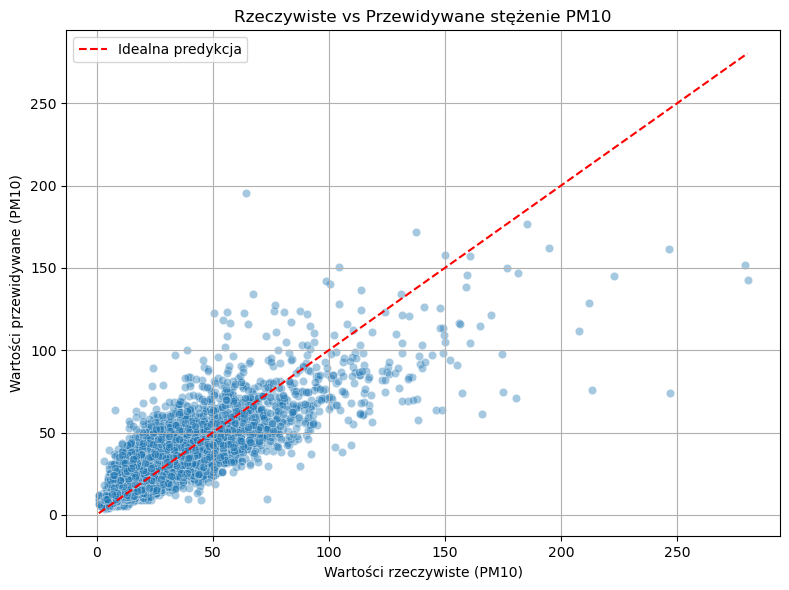

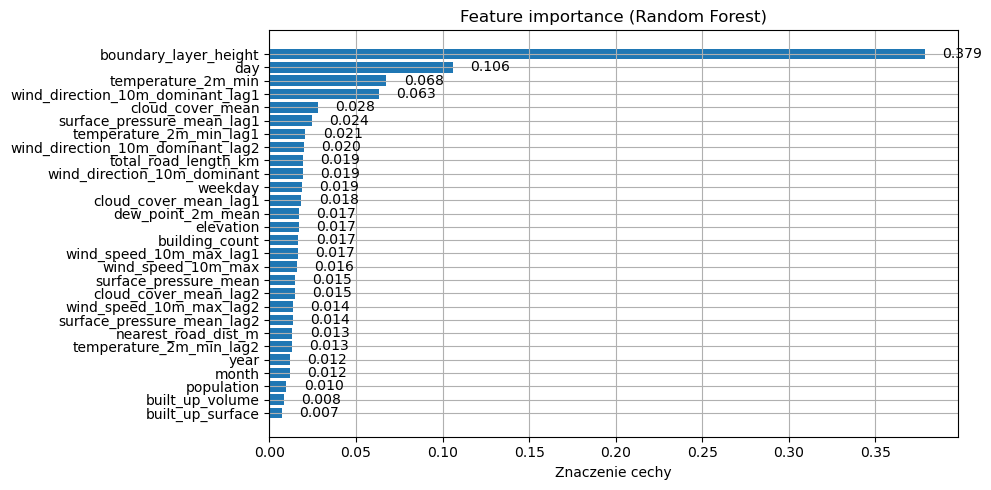

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rf.predict(X_test)
# Metryki
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Tworzymy wykres scatter z linią idealnej predykcji
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)

# Linia idealna: predykcja == rzeczywistość
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Idealna predykcja')

plt.xlabel("Wartości rzeczywiste (PM10)")
plt.ylabel("Wartości przewidywane (PM10)")
plt.title("Rzeczywiste vs Przewidywane stężenie PM10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


importances = rf.feature_importances_
feature_names = X.columns

# Posortuj cechy według znaczenia (opcjonalnie)
indices = np.argsort(importances)
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

plt.figure(figsize=(10, 5))
bars = plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Znaczenie cechy')
plt.title('Feature importance (Random Forest)')
plt.grid(True)

# Dodaj wartości liczbowe do końca słupków
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center')

plt.tight_layout()
plt.show()